In [1]:
import sys
print(sys.version)

3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
import gc
import time
from contextlib import contextmanager

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import Fonctions_P7 as fct_model

C:\Users\steph\anaconda3\envs\new_env_p8_v2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
application_test = pd.read_csv("application_test.csv", sep = ',')
application_train = pd.read_csv("application_train.csv", sep = ',')
bureau = pd.read_csv("bureau.csv", sep = ',')
bureau_balance = pd.read_csv("bureau_balance.csv", sep = ',')
credit_card_balance = pd.read_csv("credit_card_balance.csv", sep = ',')
HomeCredit_columns_description = pd.read_csv("HomeCredit_columns_description.csv", sep = ',')
installments_payments = pd.read_csv("installments_payments.csv", sep = ',')
POS_CASH_balance = pd.read_csv("POS_CASH_balance.csv", sep = ',')
previous_application = pd.read_csv("previous_application.csv", sep = ',')
sample_submission = pd.read_csv("sample_submission.csv", sep = ',')


In [5]:
pd.options.display.max_columns = None

In [6]:
application_test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

# Etude application_train

In [7]:
application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [8]:
print(application_train['TARGET'].value_counts(normalize = True))

0    0.919271
1    0.080729
Name: TARGET, dtype: float64


In [9]:
print(application_train['CODE_GENDER'].value_counts())
print(pd.crosstab(application_train['CODE_GENDER'], application_train['TARGET'] , normalize = 'index'))

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
TARGET              0         1
CODE_GENDER                    
F            0.930007  0.069993
M            0.898581  0.101419
XNA          1.000000  0.000000


In [10]:
print(application_train['FLAG_OWN_CAR'].value_counts())
print(pd.crosstab(application_train['FLAG_OWN_CAR'],application_train['TARGET'], normalize = 'index' ))

N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64
TARGET               0         1
FLAG_OWN_CAR                    
N             0.914998  0.085002
Y             0.927563  0.072437


In [11]:
print(application_train['FLAG_OWN_REALTY'].value_counts())
print(pd.crosstab(application_train['FLAG_OWN_REALTY'],application_train['TARGET'], normalize = 'index' ))

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
TARGET                  0         1
FLAG_OWN_REALTY                    
N                0.916751  0.083249
Y                0.920384  0.079616


In [12]:
print(application_train['NAME_HOUSING_TYPE'].value_counts())
print(pd.crosstab(application_train['NAME_HOUSING_TYPE'],application_train['TARGET'] , normalize = 'index'))

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64
TARGET                      0         1
NAME_HOUSING_TYPE                      
Co-op apartment      0.920677  0.079323
House / apartment    0.922043  0.077957
Municipal apartment  0.914603  0.085397
Office apartment     0.934276  0.065724
Rented apartment     0.876869  0.123131
With parents         0.883019  0.116981


In [13]:
print(application_train['OCCUPATION_TYPE'].value_counts())
print(pd.crosstab(application_train['OCCUPATION_TYPE'],application_train['TARGET'], normalize = 'index' ))

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64
TARGET                        0         1
OCCUPATION_TYPE                          
Accountants            0.951697  0.048303
Cleaning staff         0.903933  0.096067
Cooking staff          0.895560  0.104440
Core staff             0.936960  0.063040
Drivers                0.886739  0.113261
HR staff               0.936057  0.063943
High skill tech staff  0.938401  0.061599
IT staff               0.935

In [14]:
print(application_train['FLAG_OWN_REALTY'].value_counts())
print(pd.crosstab(application_train['FLAG_OWN_REALTY'],application_train['TARGET'] , normalize = 'index'))

Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
TARGET                  0         1
FLAG_OWN_REALTY                    
N                0.916751  0.083249
Y                0.920384  0.079616


## Autres datasets

In [15]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [16]:
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [17]:
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [18]:
HomeCredit_columns_description.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [19]:
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

In [20]:
POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [21]:
sample_submission.head()

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

In [22]:
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

## Etude du preprocessing

In [23]:
with pd.option_context('display.max_rows', None) :
    print((application_train.isnull().sum()).sort_values())

SK_ID_CURR                           0
HOUR_APPR_PROCESS_START              0
REG_REGION_NOT_WORK_REGION           0
LIVE_REGION_NOT_WORK_REGION          0
REG_CITY_NOT_LIVE_CITY               0
REG_CITY_NOT_WORK_CITY               0
LIVE_CITY_NOT_WORK_CITY              0
ORGANIZATION_TYPE                    0
FLAG_DOCUMENT_21                     0
FLAG_DOCUMENT_20                     0
FLAG_DOCUMENT_19                     0
FLAG_DOCUMENT_18                     0
FLAG_DOCUMENT_17                     0
FLAG_DOCUMENT_16                     0
FLAG_DOCUMENT_15                     0
FLAG_DOCUMENT_14                     0
FLAG_DOCUMENT_13                     0
FLAG_DOCUMENT_12                     0
FLAG_DOCUMENT_11                     0
FLAG_DOCUMENT_10                     0
FLAG_DOCUMENT_9                      0
FLAG_DOCUMENT_8                      0
FLAG_DOCUMENT_7                      0
FLAG_DOCUMENT_6                      0
FLAG_DOCUMENT_5                      0
FLAG_DOCUMENT_4          

In [24]:
# Pb days employed sur le max

print(application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED'] == 365243 ].count())
print(application_train['DAYS_EMPLOYED'][application_train['DAYS_EMPLOYED'] >0].count())

55374
55374


In [25]:
application_train.describe().T.sort_values(ascending = 0,by = "mean").style.background_gradient(cmap = "BuGn").bar(subset = ["std"], color ="red").bar(subset = ["mean"], color ="blue")

In [26]:
application_train.describe(include='object').T.sort_values(ascending = 0,by = "top").style.background_gradient(cmap = "BuGn").bar(subset = ["freq"], color ="crimson").bar(subset = ["unique"], color ="orange").bar(subset = ["count"], color ="pink")

# Creation de la base de modélisation

In [27]:
app_train = fct_model.application_train()

Train samples: 307511
                               count  percentage
SK_ID_CURR                         0        0.00
HOUR_APPR_PROCESS_START            0        0.00
REG_REGION_NOT_WORK_REGION         0        0.00
LIVE_REGION_NOT_WORK_REGION        0        0.00
REG_CITY_NOT_LIVE_CITY             0        0.00
REG_CITY_NOT_WORK_CITY             0        0.00
LIVE_CITY_NOT_WORK_CITY            0        0.00
ORGANIZATION_TYPE                  0        0.00
FLAG_DOCUMENT_21                   0        0.00
FLAG_DOCUMENT_20                   0        0.00
FLAG_DOCUMENT_19                   0        0.00
FLAG_DOCUMENT_18                   0        0.00
FLAG_DOCUMENT_17                   0        0.00
FLAG_DOCUMENT_16                   0        0.00
WEEKDAY_APPR_PROCESS_START         0        0.00
FLAG_DOCUMENT_15                   0        0.00
FLAG_DOCUMENT_13                   0        0.00
FLAG_DOCUMENT_12                   0        0.00
FLAG_DOCUMENT_11                   0        0.0

## Valeurs Manquantes

In [28]:
# corralation avec la cible
#np.abs(app_train.corr()['TARGET']).sort_values(ascending = False).iloc[:30]

In [29]:
#import matplotlib.pyplot as plt
#for var in data.columns :
#    sns.lineplot(data = data, x = var, hue = 'TARGET')
#    
#    plt.show()

In [30]:
app_train.describe().T.sort_values(ascending = 0,by = "mean").style.background_gradient(cmap = "BuGn").bar(subset = ["std"], color ="red").bar(subset = ["mean"], color ="blue")

In [31]:
%matplotlib inline

# Test Modélisation

## Creation Base train et test

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit



Variables = [f for f in app_train.columns if f not in ['SK_ID_CURR', 'index']]
data=app_train[Variables]

# classification déséquilibrée donc utilisation d'une stratification aléatoire afin d'avoir un nombre 
#d'individus de chaque classe nécessaie dans chaque dataset
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 0) 

X, y = data.drop(['TARGET'], axis = 1), data['TARGET']
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#test_data = app_train_test[app_train_test['TARGET'].isna()][Variables]

## SMOTE

In [34]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE(random_state = 0).fit_resample(X_train, y_train)

## Comparaison différents types de modèles avec/ sans SMOTE

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

classifier_gbc = make_pipeline(StandardScaler(), GradientBoostingClassifier(verbose = True))
classifier_log = make_pipeline(StandardScaler(), LogisticRegression(verbose = True))

Classifier_gbc_na , score  = fct_model.train_score_model(classifier_gbc ,X_train, y_train, X_test, y_test)
print('AUC Gradient Boosting classifier : ', score)
print(fct_model.feature_importance_model(Classifier_gbc_na
                                         , X_train).sort_values(by = 'imp',ascending = False).iloc[:10])


Classifier_log_na , score  = fct_model.train_score_model(classifier_log ,X_train, y_train, X_test, y_test)
print('AUC logistic : ', score)
print(fct_model.feature_importance_model(Classifier_log_na
                                         , X_train).sort_values(by = 'imp',ascending = False).iloc[:10])


classifier_gbc = make_pipeline(StandardScaler(), GradientBoostingClassifier(verbose = True))
Classifier_gbc_smote , score  = fct_model.train_score_model(classifier_gbc ,X_resampled, y_resampled, X_test, y_test)
print('AUC Gradient Boosting classifier SMOTE: ', score)
print(fct_model.feature_importance_model(Classifier_gbc_smote
                                         , X_resampled).sort_values(by = 'imp',ascending = False).iloc[:10])


classifier_log = make_pipeline(StandardScaler(), LogisticRegression(verbose = True))
Classifier_log_smote , score  = fct_model.train_score_model(classifier_log ,X_resampled, y_resampled, X_test, y_test)
print('AUC logistic SMOTE : ', score)
print(fct_model.feature_importance_model(Classifier_log_smote
                                         , X_resampled).sort_values(by = 'imp',ascending = False).iloc[:10])



#classifier_gbr.fit(X_train,y_train)
#print('perf GBR sans resampling : ', roc_auc_score(y_test, [i[1] for i in classifier_gbr.predict_proba(X_test)]))
#Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = classifier_gbr[-1].feature_importances_
#Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:30])
#classifier_gbr.fit(X_resampled,y_resampled)
#print('perf GBR avec resampling : ', roc_auc_score(y_test, [i[1] for i in classifier_gbr.predict_proba(X_test)]))
#Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = classifier_gbr[-1].feature_importances_
#"""Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:30])
#classifier_log.fit(X_train,y_train)
#print('perf log sans resampling : ', roc_auc_score(y_test, [i[1] for i in classifier_log.predict_proba(X_test)]))
#"Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = np.abs(classifier_log[-1].coef_[0])
#Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:40])
#classifier_log.fit(X_resampled,y_resampled)
#print('perf log avec resampling : ', roc_auc_score(y_test, [i[1] for i in classifier_log.predict_proba(X_test)]))
#Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = np.abs(classifier_log[-1].coef_[0])
#Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:40])





      Iter       Train Loss   Remaining Time 
         1           0.5536            3.65m
         2           0.5479            3.58m
         3           0.5433            3.56m
         4           0.5396            3.50m
         5           0.5362            3.48m
         6           0.5336            3.42m
         7           0.5309            3.38m
         8           0.5287            3.35m
         9           0.5269            3.31m
        10           0.5247            3.27m
        20           0.5127            2.91m
        30           0.5062            2.53m
        40           0.5021            2.17m
        50           0.4989            1.81m
        60           0.4966            1.44m
        70           0.4946            1.08m
        80           0.4930           43.14s
        90           0.4917           21.54s
       100           0.4905            0.00s
AUC Gradient Boosting classifier :  0.7574438450050412
         imp                              Va

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.1s finished


AUC logistic :  0.7312869204739707
         imp                  Variable
29  0.388353              EXT_SOURCE_2
30  0.344123              EXT_SOURCE_3
5   0.311962                AMT_CREDIT
6   0.229134               AMT_ANNUITY
80  0.221075              PAYMENT_RATE
51  0.201891           FLAG_DOCUMENT_3
95  0.181234  NAME_INCOME_TYPE_Working
28  0.170114              EXT_SOURCE_1
1   0.136188              FLAG_OWN_CAR
0   0.133993               CODE_GENDER
      Iter       Train Loss   Remaining Time 
         1           1.3179           10.03m
         2           1.2693           10.00m
         3           1.2175            9.84m
         4           1.1738            9.71m
         5           1.1415            9.61m
         6           1.0979            9.48m
         7           1.0721            9.39m
         8           1.0381            9.30m
         9           1.0161            9.20m
        10           0.9845            9.08m
        20           0.7962            8

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s finished


AUC logistic SMOTE :  0.7158750096041986
          imp                                           Variable
14   4.855554                                     FLAG_EMP_PHONE
102  4.123467                         NAME_FAMILY_STATUS_Married
100  3.410675  NAME_EDUCATION_TYPE_Secondary / secondary special
136  2.991930                 WEEKDAY_APPR_PROCESS_START_TUESDAY
137  2.920154               WEEKDAY_APPR_PROCESS_START_WEDNESDAY
132  2.907571                  WEEKDAY_APPR_PROCESS_START_MONDAY
135  2.901535                WEEKDAY_APPR_PROCESS_START_THURSDAY
131  2.899170                  WEEKDAY_APPR_PROCESS_START_FRIDAY
143  2.785865           ORGANIZATION_TYPE_Business Entity Type 3
97   2.695869               NAME_EDUCATION_TYPE_Higher education


In [36]:
print(fct_model.feature_importance_model(Classifier_gbc_na, X_train).sort_values(by = 'imp',ascending = False).iloc[:10])

         imp                              Variable
30  0.318610                          EXT_SOURCE_3
29  0.306179                          EXT_SOURCE_2
80  0.089666                          PAYMENT_RATE
28  0.059232                          EXT_SOURCE_1
9   0.041434                         DAYS_EMPLOYED
8   0.039156                            DAYS_BIRTH
0   0.019511                           CODE_GENDER
97  0.014701  NAME_EDUCATION_TYPE_Higher education
51  0.009337                       FLAG_DOCUMENT_3
6   0.008715                           AMT_ANNUITY


In [37]:
#feat_imp_log_smote = fct_model.feature_importance_model(Classifier_log_smote, X_resampled)

#print(feat_imp_log_smote.sort_values(by = 'imp', ascending = False).iloc[:30])

In [38]:
#Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = classifier_gbr[-1].feature_importances_
#Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:30])

In [39]:
#Feat_imp = pd.DataFrame({})

#Feat_imp['imp'] = np.abs(classifier_log[-1].coef_[0])
#Feat_imp['Variable'] = X_train.columns
#print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:40])

## xgboost

In [89]:
import xgboost as xgb

D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations
model = xgb.train(param, D_train, steps)

preds = model.predict(D_test)
print(preds)
#best_preds = np.asarray([np.argmax(line) for line in preds])
print(roc_auc_score(y_test, [i[1] for i in model.predict(D_test)]))



#from sklearn.model_selection import GridSearchCV
#
#clf = xgb.XGBClassifier()
#"parameters = {
#     "eta"    : [0.05, 0.15, 0.25] ,
##     "max_depth"        : [ 3, 5, 8, 12],
#     "min_child_weight" : [ 1, 3, 7 ],
#     "gamma"            : [ 0.0, 0.1 , 0.4 ],
# ""    "colsample_bytree" : [ 0.4,  0.7 ]
#     }

#grid = GridSearchCV(clf,
#                    parameters, n_jobs=4,
#" "                   scoring="roc_auc",
#                    cv=3,
#                   verbose = 5)
#
#grid.fit(X_train, y_train)





[[0.9772701  0.02272986]
 [0.85037607 0.1496239 ]
 [0.9051053  0.09489475]
 ...
 [0.8916472  0.10835281]
 [0.9230513  0.07694875]
 [0.9740427  0.02595727]]
0.7467401483791622


# SHAP values

In [41]:
import shap

In [42]:
shap_values, observations = fct_model.local_interpretability_shap(Classifier_gbc_na, X_test)

In [43]:
#pred = classifier_gbr.predict(X_test)
#explainer = shap.TreeExplainer(classifier_gbr[-1])
#"observations = classifier_gbr[0].transform(X_test)
#shap_values = explainer.shap_values(observations)
#print(np.abs(shap_values.sum(1) + explainer.expected_value - pred).max())

In [44]:
#print(shap_values.shape)

In [45]:
print(observations)

[[ 0.72146637  1.39327724 -0.66468561 ... -0.51604962 -0.13334223
  -0.08771749]
 [-1.386066    1.39327724 -0.66468561 ... -0.51604962 -0.13334223
  -0.08771749]
 [-1.386066    1.39327724 -0.66468561 ... -0.51604962 -0.13334223
  -0.08771749]
 ...
 [-1.386066    1.39327724 -0.66468561 ... -0.51604962 -0.13334223
  -0.08771749]
 [ 0.72146637 -0.71773224 -0.66468561 ...  1.93779814 -0.13334223
  -0.08771749]
 [-1.386066   -0.71773224 -0.66468561 ... -0.51604962 -0.13334223
  -0.08771749]]


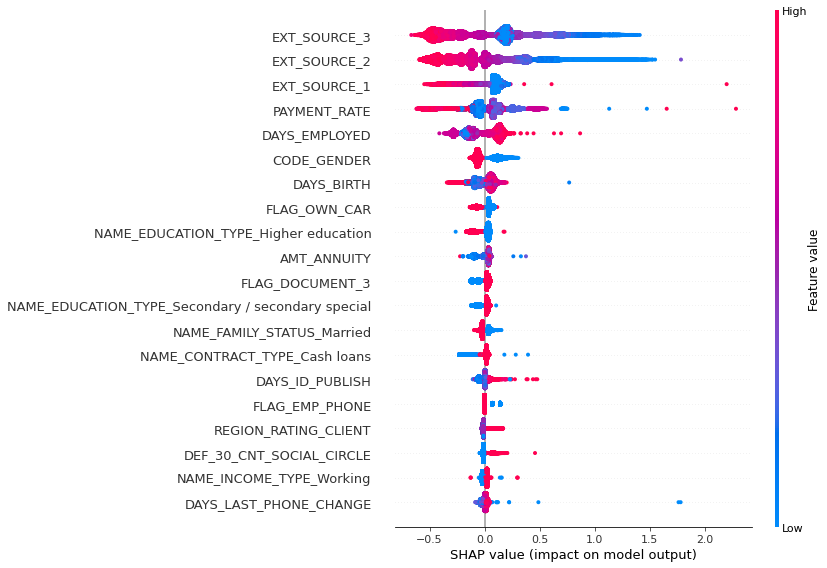

In [46]:
shap.initjs()
shap.summary_plot(shap_values, observations, feature_names = X_test.columns)

# LIME

In [47]:
import lime
from lime import lime_tabular

#explainer = lime_tabular.LimeTabularExplainer(
#    training_data = np.array(X_train),
#    feature_names = X_train.columns,
#    class_names = [0, 1],
#    mode = 'classification'
#)
#classifier_gbc = make_pipeline(StandardScaler(), GradientBoostingClassifier(verbose = True))
#Classifier_gbc_na , score  = fct_model.train_score_model(classifier_gbc ,X_train, y_train, X_test, y_test)

exp = fct_model.local_interpretability_lime(Classifier_gbc_na, X_train, X_test, 0)


X does not have valid feature names, but StandardScaler was fitted with feature names


In [48]:
X_train.head()

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
96488             1             0                0             0   
196993            0             1                0             1   
155398            0             1                0             0   
218104            0             0                0             0   
207810            1             0                1             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  \
96488            67500.0    314100.0      13306.5                    0.028663   
196993          112500.0    247675.5      26136.0                    0.018850   
155398          180000.0    835380.0      42651.0                    0.018029   
218104          157500.0    529348.5      39708.0                    0.020713   
207810           90000.0    900000.0      24880.5                    0.010643   

        DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
96488       -22074   -2384.142254            -2643.0            -4310   
196993      -18574   -6318.000000            -6443.0            -2102   
155398      -18578   -2601.000000            -3680.0            -2108   
218104      -20460   -1002.000000            -2001.0            -3899   
207810      -13734    -378.000000            -7855.0            -4038   

        OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
96488           0.0           1               0                0   
196993         12.0           1               1                0   
155398          2.0           1               1                0   
218104          0.0           1               1                0   
207810          0.0           1               1                0   

        FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
96488                  1           0           0              2.0   
196993                 1           0           1              3.0   
155398                 1           0           0              2.0   
218104                 1           0           0              2.0   
207810                 1           1           0              2.0   

        REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
96488                      2                       14   
196993                     2                       12   
155398                     3                        9   
218104                     3                        6   
207810                     2                       15   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
96488                            0                           0   
196993                           0                           0   
155398                           0                           0   
218104                           0                           0   
207810                           0                           0   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
96488                             0                       0   
196993                            0                       0   
155398                            0                       0   
218104                            0                       0   
207810                            0                       0   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
96488                        0                        0      0.000000   
196993                       1                        1      0.812777   
155398                       0                        0      0.000000   
218104                       0                        0      0.000000   
207810                       0                        0      0.000000   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
96488       0.227658      0.339288          0.0000            0.0000   
196993      0.617263      0.758393          0.0000            0.0000   
155398      0.700521      0.000000          0.0000            0.0000   
218

In [49]:
#print(classifier_gbr.predict_proba(X_test))

In [50]:
#exp = explainer.explain_instance(
#""    data_row = X_test.iloc[0], 
#    predict_fn = classifier_gbr.predict_proba
#)

exp.show_in_notebook(show_table=True)

In [51]:
%matplotlib inline

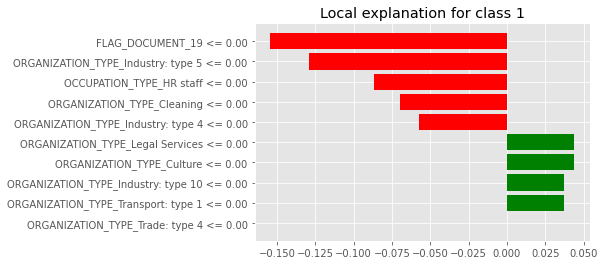

In [52]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()
    plt.show()

In [53]:
print(exp.as_list())

[('FLAG_DOCUMENT_19 <= 0.00', -0.15459762217073525), ('ORGANIZATION_TYPE_Industry: type 5 <= 0.00', -0.12923248051442368), ('OCCUPATION_TYPE_HR staff <= 0.00', -0.08647396144370327), ('ORGANIZATION_TYPE_Cleaning <= 0.00', -0.0698724874061489), ('ORGANIZATION_TYPE_Industry: type 4 <= 0.00', -0.05751401392068039), ('ORGANIZATION_TYPE_Legal Services <= 0.00', 0.04398084543592367), ('ORGANIZATION_TYPE_Culture <= 0.00', 0.0438417953019864), ('ORGANIZATION_TYPE_Industry: type 10 <= 0.00', 0.03743957234496996), ('ORGANIZATION_TYPE_Transport: type 1 <= 0.00', 0.037109335617990055), ('ORGANIZATION_TYPE_Trade: type 4 <= 0.00', -4.492241661099108e-05)]


# Feature selection

In [54]:
#https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()

X_train_ = Scaler.fit_transform(X_train)
X_test_ = Scaler.transform(X_test)

In [55]:
num_feats = 30
X_train_= pd.DataFrame(X_train_, columns = X_train.columns)
cor_support, cor_feature = fct_model.cor_selector(X_train_, y_train,num_feats) # correlation
chi_support, chi_feature = fct_model.chi_selector(X_train_, y_train,num_feats) #chi2
rfe_support, rfe_feature = fct_model.rfe_selector(X_train_, y_train,num_feats) # backwards logistic
embeded_lr_support, embeded_lr_feature = fct_model.embeded_selector(X_train_, y_train,num_feats, LogisticRegression(penalty="l1", solver = 'liblinear')) # Logitic penalty
embeded_rf_support, embeded_rf_feature = fct_model.embeded_selector(X_train_, y_train,num_feats, RandomForestClassifier(n_estimators=100, verbose = 5)) # Random Forest
embeded_gbc_support, embeded_gbc_feature = fct_model.embeded_selector(X_train_, y_train,num_feats, GradientBoostingClassifier(n_estimators=100, verbose = 5)) # Gradient Boosting


invalid value encountered in true_divide
invalid value encountered in true_divide


Fitting estimator with 210 features.
Fitting estimator with 180 features.
Fitting estimator with 150 features.
Fitting estimator with 120 features.
Fitting estimator with 90 features.
Fitting estimator with 60 features.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


building tree 3 of 100


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s


building tree 4 of 100


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.3s remaining:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished


      Iter       Train Loss   Remaining Time 
         1           0.5536            3.56m
         2           0.5479            3.56m
         3           0.5433            3.51m
         4           0.5396            3.49m
         5           0.5362            3.49m
         6           0.5336            3.43m
         7           0.5309            3.42m
         8           0.5287            3.37m
         9           0.5269            3.33m
        10           0.5247            3.30m
        11           0.5231            3.26m
        12           0.5218            3.22m
        13           0.5204            3.18m
        14           0.5193            3.15m
        15           0.5183            3.10m
        16           0.5168            3.07m
        17           0.5158            3.03m
        18           0.5149            3.00m
        19           0.5137            2.96m
        20           0.5127            2.92m
        21           0.5120            2.89m
        2

In [56]:
feature_name = X_train.columns
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'Gradient Boosting' : embeded_gbc_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(3*num_feats)

Feature  Pearson  Chi-2    RFE  Logistics  \
1                          EXT_SOURCE_3     True   True   True       True   
2                          EXT_SOURCE_2     True   True   True       True   
3                          EXT_SOURCE_1     True   True   True       True   
4                            DAYS_BIRTH     True   True   True       True   
5                       FLAG_DOCUMENT_3     True   True   True       True   
..                                  ...      ...    ...    ...        ...   
86           REG_REGION_NOT_WORK_REGION    False  False  False      False   
87           REG_REGION_NOT_LIVE_REGION    False  False  False      False   
88         ORGANIZATION_TYPE_University    False  False  False      False   
89  ORGANIZATION_TYPE_Transport: type 4    False  False  False      False   
90  ORGANIZATION_TYPE_Transport: type 3    False  False  False      False   

    Random Forest  Gradient Boosting  Total  
1            True               True      6  
2            True               True      6  
3            True               True      6  
4            True               True      6  
5           False               True      5  
..            ...                ...    ...  
86          False              False      0  
87          False              False      0  
88          False              False      0  
89          False              False      0  
90          False              False      0  

[90 rows x 8 columns]

In [57]:
feat_importante = feature_selection_df.iloc[:3*num_feats]['Feature']
X_train_fs = X_train[feat_importante]
X_test_fs = X_test[feat_importante]
model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', verbose = True))
model.fit(X_train_fs, y_train)

print('perf logistique avec feature selecte : ', roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test_fs)]))

model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', verbose = True))
model.fit(X_train, y_train)

print('perf logistique avec all feature : ', roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test)]))

[LibLinear]perf logistique avec feature selecte :  0.7298992485881151
[LibLinear]perf logistique avec all feature :  0.731302940201958


In [58]:
feat_importante = feature_selection_df.iloc[:num_feats]['Feature']
X_train_fs = X_train[feat_importante]
X_test_fs = X_test[feat_importante]
model = make_pipeline(StandardScaler(), LogisticRegression(solver='liblinear', verbose = True))
model.fit(X_train_fs, y_train)

print('perf logistique avec feature selecte : ', roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test_fs)]))

[LibLinear]perf logistique avec feature selecte :  0.7261298243772224


In [59]:
feat_importante = feature_selection_df.iloc[:num_feats]['Feature']
X_train_fs = X_train[feat_importante]
X_test_fs = X_test[feat_importante]
model = make_pipeline(StandardScaler(), GradientBoostingClassifier( verbose = 10))
model.fit(X_train_fs, y_train)

print('perf gbc avec feature selecte : ', roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test_fs)]))

      Iter       Train Loss   Remaining Time 
         1           0.5536            1.48m
         2           0.5479            1.47m
         3           0.5433            1.47m
         4           0.5396            1.45m
         5           0.5362            1.45m
         6           0.5336            1.43m
         7           0.5309            1.41m
         8           0.5287            1.39m
         9           0.5269            1.38m
        10           0.5247            1.37m
        11           0.5231            1.36m
        12           0.5218            1.34m
        13           0.5204            1.32m
        14           0.5193            1.31m
        15           0.5183            1.29m
        16           0.5168            1.28m
        17           0.5158            1.26m
        18           0.5149            1.25m
        19           0.5137            1.24m
        20           0.5127            1.23m
        21           0.5119            1.21m
        2

## Modele tuné

In [60]:
from sklearn.model_selection import GridSearchCV
# Avec recherche hyperparam

feat_importante = feature_selection_df.iloc[:num_feats]['Feature']
X_train_fs = X_train[feat_importante]
X_test_fs = X_test[feat_importante]

In [61]:
model = make_pipeline(StandardScaler(), GradientBoostingClassifier( verbose = 10))


param_grid_gbc = {
    'gradientboostingclassifier__learning_rate' : np.linspace(10**(-2), 1, 3),
    'gradientboostingclassifier__n_estimators' : [50, 100, 200],
    'gradientboostingclassifier__max_depth' : [3, 4]
}

model_tune = GridSearchCV(model, param_grid = param_grid_gbc, cv = 5, verbose = 10, n_jobs = -1, scoring = 'roc_auc')
model_tune.fit(X_train_fs, y_train)


print('perf gbc avec feature selecte : ', roc_auc_score(y_test, [i[1] for i in model_tune.predict_proba(X_test_fs)]))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
      Iter       Train Loss   Remaining Time 
         1           0.5332            1.52m
         2           0.5241            1.49m
         3           0.5161            1.47m
         4           0.5118            1.45m
         5           0.5084            1.46m
         6           0.5058            1.44m
         7           0.5044            1.42m
         8           0.5027            1.40m
         9           0.5017            1.38m
        10           0.5001            1.37m
        11           0.4993            1.35m
        12           0.4986            1.33m
        13           0.4975            1.32m
        14           0.4970            1.30m
        15           0.4964            1.29m
        16           0.4960            1.27m
        17           0.4955            1.25m
        18           0.4950            1.23m
        19           0.4944            1.21m
        20           0.4939           

In [62]:
import pickle


with open('classifier.pkl', 'wb') as f:
    pickle.dump(model_tune, f)

In [63]:
pickle_in = open("classifier.pkl","rb")
model_tune = pickle.load(pickle_in)

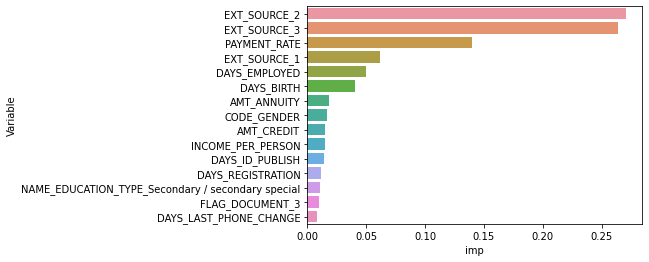

In [64]:
#fct_model.feature_importance_model(model_tune.best_estimator_, X_train)



Feat_imp = pd.DataFrame({})

Feat_imp['imp'] = np.abs(model_tune.best_estimator_[-1].feature_importances_)
Feat_imp['Variable'] = X_train_fs.columns
sns.barplot(data =  Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:15], y = 'Variable', x = 'imp')
plt.show()


## Comportement du modéle tuné avec feature select

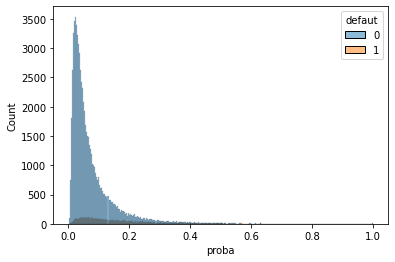

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
invalid value encountered in true_divide
invalid value encountered in true_divide
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed

########
-0.01  : Accepte :  0 
 Rejete : 76877
Tx de rejete:  1.0
Tx de defaut Accepte nan
Tx de defaut rejete 0.08072635508669693
########
0.024827586206201957  : Accepte :  16615 
 Rejete : 60262
Tx de rejete:  0.7838755414493281
Tx de defaut Accepte 0.01757448089076136
Tx de defaut rejete 0.0981381301649464
########
0.059655172412403916  : Accepte :  43597 
 Rejete : 33280
Tx de rejete:  0.4328993066847041
Tx de defaut Accepte 0.030827809252930247
Tx de defaut rejete 0.14609375
########
0.09448275861860587  : Accepte :  56595 
 Rejete : 20282
Tx de rejete:  0.263824030594326
Tx de defaut Accepte 0.041717466207262126
Tx de defaut rejete 0.18957696479637118
########
0.12931034482480783  : Accepte :  63485 
 Rejete : 13392
Tx de rejete:  0.17420034600725834
Tx de defaut Accepte 0.04996455855713948
Tx de defaut rejete 0.2265531660692951
########
0.1641379310310098  : Accepte :  67769 
 Rejete : 9108
Tx de rejete:  0.11847496650493645
Tx de defaut Accepte 0.05633844383125028
Tx de defau

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame

########
0.6865517241240392  : Accepte :  76779 
 Rejete : 98
Tx de rejete:  0.0012747635833864485
Tx de defaut Accepte 0.08032144206098021
Tx de defaut rejete 0.3979591836734694
########
0.7213793103302412  : Accepte :  76800 
 Rejete : 77
Tx de rejete:  0.0010015999583750667
Tx de defaut Accepte 0.08049479166666666
Tx de defaut rejete 0.3116883116883117
########
0.7562068965364431  : Accepte :  76818 
 Rejete : 59
Tx de rejete:  0.0007674597083653108
Tx de defaut Accepte 0.08059309016116015
Tx de defaut rejete 0.2542372881355932
########
0.7910344827426451  : Accepte :  76823 
 Rejete : 54
Tx de rejete:  0.0007024207500292676
Tx de defaut Accepte 0.08060086172109915
Tx de defaut rejete 0.25925925925925924
########
0.825862068948847  : Accepte :  76833 
 Rejete : 44
Tx de rejete:  0.000572342833357181
Tx de defaut Accepte 0.0806424322882095
Tx de defaut rejete 0.22727272727272727
########
0.8606896551550489  : Accepte :  76836 
 Rejete : 41
Tx de rejete:  0.000533319458355555
Tx de de

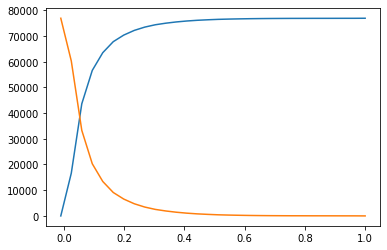

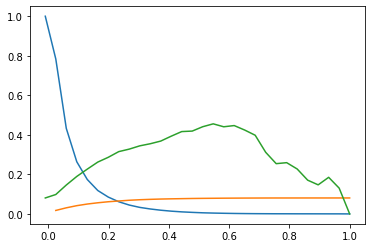

In [65]:
fct_model.impact_proba(model_tune, X_test_fs, y_test)

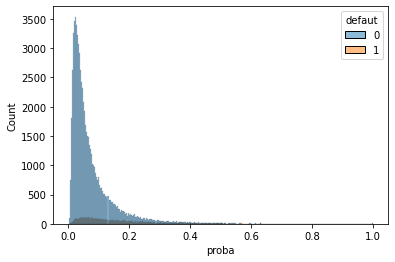

In [66]:
defaut = pd.DataFrame({})
defaut['defaut'] = y_test
defaut['proba'] =[i[1] for i in model_tune.predict_proba(X_test_fs)]

sns.histplot(data= defaut, x= 'proba', hue = 'defaut')
plt.show()

In [67]:
seuils = np.linspace(-0.01, defaut['proba'].max(), 30)

liste_accepte=[]
liste_rejete=[]
liste_tx_rejete=[]
liste_tx_defaut_accepte=[]
liste_tx_defaut_rejete = []



for seuil in seuils:
    defaut[f'Dossiers_rejete_{round(seuil, 3)}'] = np.where(
        defaut['proba'] < seuil, 0, 1)
    Nb_dossiers = defaut[f'Dossiers_rejete_{round(seuil, 3)}'].count()
    Nb_dossiers_rejete = defaut[f'Dossiers_rejete_{round(seuil, 3)}'].sum()
    Nb_dossiers_accepte = Nb_dossiers - Nb_dossiers_rejete
    Nb_dossiers_defaut_accepte = defaut[defaut['defaut'] == 1][
        defaut[f'Dossiers_rejete_{round(seuil, 3)}'] ==
        0][f'Dossiers_rejete_{round(seuil, 3)}'].count()
    Nb_dossiers_defaut_rejete = defaut[defaut['defaut'] == 1][
        defaut[f'Dossiers_rejete_{round(seuil, 3)}'] ==
        1][f'Dossiers_rejete_{round(seuil, 3)}'].count()
    
    liste_accepte.append(Nb_dossiers_accepte)
    liste_rejete.append(Nb_dossiers_rejete)
    liste_tx_rejete.append( Nb_dossiers_rejete / Nb_dossiers)
    liste_tx_defaut_accepte.append(Nb_dossiers_defaut_accepte / (Nb_dossiers_accepte))
    liste_tx_defaut_rejete.append(Nb_dossiers_defaut_rejete/ Nb_dossiers_rejete)
    print('########')
    print(seuil, ' : Accepte : ',Nb_dossiers_accepte ,
          '\n Rejete :', Nb_dossiers_rejete)
    print('Tx de rejete: ', Nb_dossiers_rejete / Nb_dossiers)
    print('Tx de defaut Accepte',
          Nb_dossiers_defaut_accepte / (Nb_dossiers_accepte))
    print('Tx de defaut rejete', Nb_dossiers_defaut_rejete/ Nb_dossiers_rejete)

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
invalid value encountered in true_divide
invalid value encountered in true_divide
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed

########
-0.01  : Accepte :  0 
 Rejete : 76877
Tx de rejete:  1.0
Tx de defaut Accepte nan
Tx de defaut rejete 0.08072635508669693
########
0.024827586206201957  : Accepte :  16615 
 Rejete : 60262
Tx de rejete:  0.7838755414493281
Tx de defaut Accepte 0.01757448089076136
Tx de defaut rejete 0.0981381301649464
########
0.059655172412403916  : Accepte :  43597 
 Rejete : 33280
Tx de rejete:  0.4328993066847041
Tx de defaut Accepte 0.030827809252930247
Tx de defaut rejete 0.14609375
########
0.09448275861860587  : Accepte :  56595 
 Rejete : 20282
Tx de rejete:  0.263824030594326
Tx de defaut Accepte 0.041717466207262126
Tx de defaut rejete 0.18957696479637118
########
0.12931034482480783  : Accepte :  63485 
 Rejete : 13392
Tx de rejete:  0.17420034600725834
Tx de defaut Accepte 0.04996455855713948
Tx de defaut rejete 0.2265531660692951
########
0.1641379310310098  : Accepte :  67769 
 Rejete : 9108
Tx de rejete:  0.11847496650493645
Tx de defaut Accepte 0.05633844383125028
Tx de defau

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame

########
0.6517241379178372  : Accepte :  76745 
 Rejete : 132
Tx de rejete:  0.0017170285000715428
Tx de defaut Accepte 0.08013551371424849
Tx de defaut rejete 0.42424242424242425
########
0.6865517241240392  : Accepte :  76779 
 Rejete : 98
Tx de rejete:  0.0012747635833864485
Tx de defaut Accepte 0.08032144206098021
Tx de defaut rejete 0.3979591836734694
########
0.7213793103302412  : Accepte :  76800 
 Rejete : 77
Tx de rejete:  0.0010015999583750667
Tx de defaut Accepte 0.08049479166666666
Tx de defaut rejete 0.3116883116883117
########
0.7562068965364431  : Accepte :  76818 
 Rejete : 59
Tx de rejete:  0.0007674597083653108
Tx de defaut Accepte 0.08059309016116015
Tx de defaut rejete 0.2542372881355932
########
0.7910344827426451  : Accepte :  76823 
 Rejete : 54
Tx de rejete:  0.0007024207500292676
Tx de defaut Accepte 0.08060086172109915
Tx de defaut rejete 0.25925925925925924
########
0.825862068948847  : Accepte :  76833 
 Rejete : 44
Tx de rejete:  0.000572342833357181
Tx de

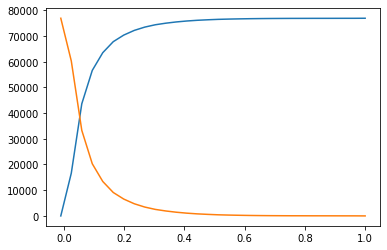

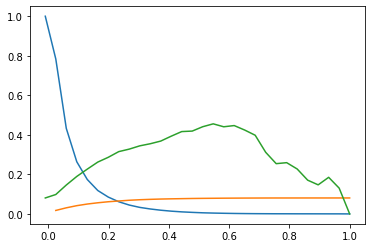

In [68]:
plt.plot(seuils, liste_accepte)
plt.plot(seuils, liste_rejete)
plt.show()
plt.plot(seuils, liste_tx_rejete)
plt.plot(seuils, liste_tx_defaut_accepte)
plt.plot(seuils, liste_tx_defaut_rejete)
plt.show()

In [69]:
defaut

defaut     proba  Dossiers_rejete_-0.01  Dossiers_rejete_0.025  \
248727       0  0.007421                      1                      0   
263686       0  0.084266                      1                      1   
264746       0  0.051576                      1                      1   
139119       0  0.034445                      1                      1   
23810        0  0.090390                      1                      1   
...        ...       ...                    ...                    ...   
95738        0  0.136252                      1                      1   
61549        0  0.076839                      1                      1   
55473        0  0.131159                      1                      1   
32719        0  0.061012                      1                      1   
52089        0  0.020767                      1                      0   

        Dossiers_rejete_0.06  Dossiers_rejete_0.094  Dossiers_rejete_0.129  \
248727                     0                      0                      0   
263686                     1                      0                      0   
264746                     0                      0                      0   
139119                     0                      0                      0   
23810                      1                      0                      0   
...                      ...                    ...                    ...   
95738                      1                      1                      1   
61549                      1                      0                      0   
55473                      1                      1                      1   
32719                      1                      0                      0   
52089                      0                      0                      0   

        Dossiers_rejete_0.164  Dossiers_rejete_0.199  Dossiers_rejete_0.234  \
248727                      0                      0                      0   
263686                      0                      0                      0   
264746                      0                      0                      0   
139119                      0                      0                      0   
23810                       0                      0                      0   
...                       ...                    ...                    ...   
95738                       0                      0                      0   
61549                       0                      0                      0   
55473                       0                      0                      0   
32719                       0                      0                      0   
52089                       0                      0                      0   

        Dossiers_rejete_0.269  Dossiers_rejete_0.303  Dossiers_rejete_0.338  \
248727                      0                      0                      0   
263686                      0                      0                      0   
264746                      0                      0                      0   
139119                      0                      0                      0   
23810                       0                      0                      0   
...                       ...                    ...                    ...   
95738                       0                      0                      0   
61549                       0                      0                      0   
55473                       0                      0                      0   
32719                       0                      0                      0   
52089                       0                      0                      0   

        Dossiers_rejete_0.373  Dossiers_rejete_0.408  Dossiers_rejete_0.443  \
248727                      0                      0                      0   
263686                      0                      0                      0   
264746                      0                  

In [70]:
import lime
from lime import lime_tabular

explainer = lime_tabular.LimeTabularExplainer(
    training_data = np.array(X_train_fs),
    feature_names = X_train_fs.columns,
    class_names = [0, 1],
    mode = 'classification'
)

In [71]:
print(model_tune.predict_proba(X_test_fs))

[[0.99257857 0.00742143]
 [0.91573368 0.08426632]
 [0.94842421 0.05157579]
 ...
 [0.86884121 0.13115879]
 [0.93898796 0.06101204]
 [0.97923304 0.02076696]]


In [72]:
exp = explainer.explain_instance(
    data_row = X_test_fs.iloc[0], 
    predict_fn = model_tune.predict_proba
)

exp.show_in_notebook(show_table=True)

X does not have valid feature names, but StandardScaler was fitted with feature names


In [73]:
%matplotlib inline

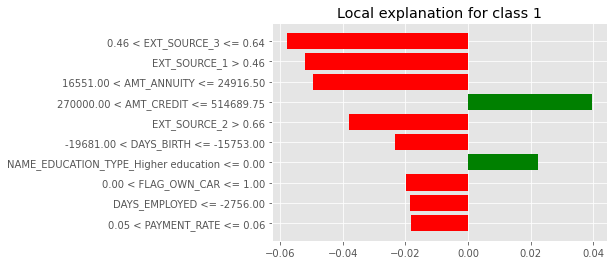

In [74]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()
    plt.show()

In [75]:
print(exp.as_list())

[('0.46 < EXT_SOURCE_3 <= 0.64', -0.057632801120134344), ('EXT_SOURCE_1 > 0.46', -0.052116027468270924), ('16551.00 < AMT_ANNUITY <= 24916.50', -0.04931512539857096), ('270000.00 < AMT_CREDIT <= 514689.75', 0.039510845150108186), ('EXT_SOURCE_2 > 0.66', -0.03794548342243844), ('-19681.00 < DAYS_BIRTH <= -15753.00', -0.023432997115987182), ('NAME_EDUCATION_TYPE_Higher education <= 0.00', 0.022432471092615324), ('0.00 < FLAG_OWN_CAR <= 1.00', -0.019772726637377093), ('DAYS_EMPLOYED <= -2756.00', -0.01856331175293946), ('0.05 < PAYMENT_RATE <= 0.06', -0.018276951307357403)]


<AxesSubplot:>

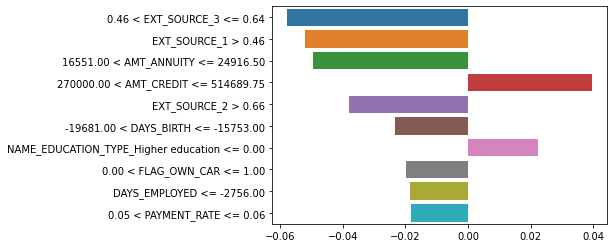

In [76]:
sns.barplot([i[1] for i in exp.as_list()], [i[0] for i in exp.as_list()])

# Essai de SMOTE sur le modèle avec moins de variable

In [77]:
from imblearn.over_sampling import SMOTE

X_resampled_fs, y_resampled_fs = SMOTE(random_state = 0).fit_resample(X_train_fs, y_train)

print(X_resampled_fs.shape)
model = GradientBoostingClassifier(n_estimators = 200,  verbose = 10)
model.fit(X_resampled_fs,y_resampled_fs)

(424022, 30)
      Iter       Train Loss   Remaining Time 
         1           1.3291            9.16m
         2           1.2867            8.97m
         3           1.2294            9.04m
         4           1.1964            8.99m
         5           1.1498            8.94m
         6           1.1214            8.85m
         7           1.0829            8.80m
         8           1.0473            8.77m
         9           1.0244            8.71m
        10           0.9953            8.67m
        11           0.9766            8.62m
        12           0.9550            8.59m
        13           0.9346            8.55m
        14           0.9078            8.51m
        15           0.8935            8.46m
        16           0.8780            8.42m
        17           0.8670            8.37m
        18           0.8460            8.33m
        19           0.8294            8.28m
        20           0.8127            8.23m
        21           0.8016            8.

GradientBoostingClassifier(n_estimators=200, verbose=10)

In [78]:
roc_auc_score(y_test, [i[1] for i in model.predict_proba(X_test_fs)])

0.7261085069210856

Au vu de la perte de performance observé suite à l'ajout des données SMOTE, cette méthode ne sera pas conservée pour le modèle final

In [79]:
Feat_imp = pd.DataFrame({})

Feat_imp['imp'] = np.abs(model.feature_importances_)
Feat_imp['Variable'] = X_train_fs.columns
print(Feat_imp.sort_values(by = 'imp', ascending = False).iloc[:40])

         imp                                           Variable
15  0.216404                        YEARS_BEGINEXPLUATATION_AVG
23  0.134414                         AMT_REQ_CREDIT_BUREAU_YEAR
0   0.113075                                       EXT_SOURCE_3
17  0.085988                                        OWN_CAR_AGE
19  0.080837                                       FLAG_OWN_CAR
7   0.071474                                        CODE_GENDER
1   0.059779                                       EXT_SOURCE_2
12  0.057580               NAME_EDUCATION_TYPE_Higher education
11  0.052735  NAME_EDUCATION_TYPE_Secondary / secondary special
2   0.033654                                       EXT_SOURCE_1
13  0.022719                                      FLOORSMAX_AVG
6   0.013086                                      DAYS_EMPLOYED
27  0.009141                         REGION_POPULATION_RELATIVE
22  0.008530                             DAYS_LAST_PHONE_CHANGE
28  0.007983                           O

## Comportement SMOTE + feat_select

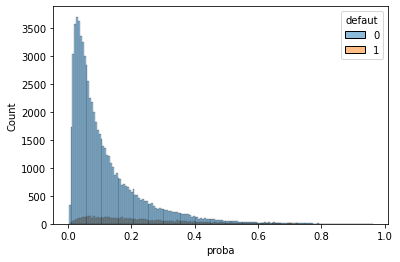

In [80]:
defaut = pd.DataFrame({})
defaut['defaut'] = y_test
defaut['proba'] =[i[1] for i in model.predict_proba(X_test_fs)]

sns.histplot(data= defaut, x= 'proba', hue = 'defaut')
plt.show()

In [81]:
seuils = np.linspace(-0.01, defaut['proba'].max(), 30)

liste_accepte=[]
liste_rejete=[]
liste_tx_rejete=[]
liste_tx_defaut_accepte=[]
liste_tx_defaut_rejete = []



for seuil in seuils:
    defaut[f'Dossiers_rejete_{round(seuil, 3)}'] = np.where(
        defaut['proba'] < seuil, 0, 1)
    Nb_dossiers = defaut[f'Dossiers_rejete_{round(seuil, 3)}'].count()
    Nb_dossiers_rejete = defaut[f'Dossiers_rejete_{round(seuil, 3)}'].sum()
    Nb_dossiers_accepte = Nb_dossiers - Nb_dossiers_rejete
    Nb_dossiers_defaut_accepte = defaut[defaut['defaut'] == 1][
        defaut[f'Dossiers_rejete_{round(seuil, 3)}'] ==
        0][f'Dossiers_rejete_{round(seuil, 3)}'].count()
    Nb_dossiers_defaut_rejete = defaut[defaut['defaut'] == 1][
        defaut[f'Dossiers_rejete_{round(seuil, 3)}'] ==
        1][f'Dossiers_rejete_{round(seuil, 3)}'].count()
    
    liste_accepte.append(Nb_dossiers_accepte)
    liste_rejete.append(Nb_dossiers_rejete)
    liste_tx_rejete.append( Nb_dossiers_rejete / Nb_dossiers)
    liste_tx_defaut_accepte.append(Nb_dossiers_defaut_accepte / (Nb_dossiers_accepte))
    liste_tx_defaut_rejete.append(Nb_dossiers_defaut_rejete/ Nb_dossiers_rejete)
    print('########')
    print(seuil, ' : Accepte : ',Nb_dossiers_accepte ,
          '\n Rejete :', Nb_dossiers_rejete)
    print('Tx de rejete: ', Nb_dossiers_rejete / Nb_dossiers)
    print('Tx de defaut Accepte',
          Nb_dossiers_defaut_accepte / (Nb_dossiers_accepte))
    print('Tx de defaut rejete', Nb_dossiers_defaut_rejete/ Nb_dossiers_rejete)

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
invalid value encountered in true_divide
invalid value encountered in true_divide
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed

########
-0.01  : Accepte :  0 
 Rejete : 76877
Tx de rejete:  1.0
Tx de defaut Accepte nan
Tx de defaut rejete 0.08072635508669693
########
0.023538535368303068  : Accepte :  7056 
 Rejete : 69821
Tx de rejete:  0.9082170219961757
Tx de defaut Accepte 0.015731292517006803
Tx de defaut rejete 0.08729465347101875
########
0.05707707073660614  : Accepte :  26843 
 Rejete : 50034
Tx de rejete:  0.650831848277118
Tx de defaut Accepte 0.026152069440822562
Tx de defaut rejete 0.11000519646640285
########
0.09061560610490922  : Accepte :  40362 
 Rejete : 36515
Tx de rejete:  0.47497951272812416
Tx de defaut Accepte 0.03505772756553194
Tx de defaut rejete 0.13120635355333424
########
0.12415414147321228  : Accepte :  49363 
 Rejete : 27514
Tx de rejete:  0.357896379931579
Tx de defaut Accepte 0.04122520916475903
Tx de defaut rejete 0.15159555135567349
########
0.15769267684151533  : Accepte :  55822 
 Rejete : 21055
Tx de rejete:  0.2738790535530783
Tx de defaut Accepte 0.047776862169037294
T

Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame index.
Boolean Series key will be reindexed to match DataFrame

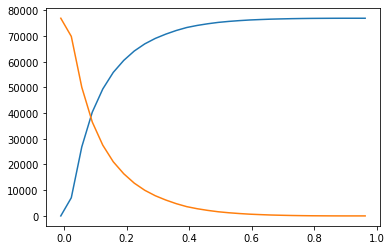

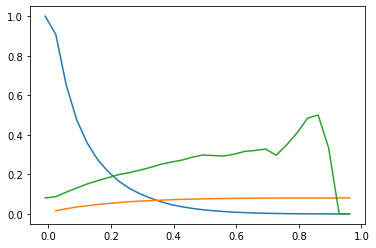

In [82]:
plt.plot(seuils, liste_accepte)
plt.plot(seuils, liste_rejete)
plt.show()
plt.plot(seuils, liste_tx_rejete)
plt.plot(seuils, liste_tx_defaut_accepte)
plt.plot(seuils, liste_tx_defaut_rejete)
plt.show()

In [83]:
index = 5 

ind_test = X_test_fs.iloc[index: index+1]
print(model.predict_proba(ind_test)[0][1])

0.03388274641730721


# Sauvegarde model et Jeu de données

In [84]:
import pickle

# Sauvegarde du jeu de Test
X_test_fs_id_cli = pd.concat([X_test_fs, app_train.iloc[test_index][['SK_ID_CURR']]], axis = 1)
with open('data_test.pkl', 'wb') as f:
    pickle.dump(X_test_fs_id_cli, f)

# Sauvegarde du jeu d'entrainement
X_train_fs_id_cli = pd.concat([X_train_fs, app_train.iloc[train_index][['SK_ID_CURR']]], axis = 1)
with open('data_train.pkl', 'wb') as f:
    pickle.dump(X_train_fs_id_cli, f)
    
# Suavegarde du modèle entrainé    
with open('classifier.pkl', 'wb') as f:
    pickle.dump(model_tune, f)
    


In [85]:
# Test de certaine fonction de l'API sur le notebook

import numpy as np
import pickle
import pandas as pd

from pydantic import BaseModel

import lime
from lime import lime_tabular
import matplotlib.pyplot as plt
import json



# 2. Create the app object
#app = FastAPI()

# Import model
pickle_in = open("classifier.pkl","rb")
classifier = pickle.load(pickle_in)

# Import data
data_test = open("data_test.pkl","rb")
data_test = pickle.load(data_test)

data_train = open("data_train.pkl","rb")
data_train = pickle.load(data_train)


explainer = lime_tabular.LimeTabularExplainer(
    training_data = np.array(data_train.drop(['SK_ID_CURR'], axis =1)),
    feature_names = data_train.drop(['SK_ID_CURR'], axis =1).columns,
    class_names = [0, 1],
    mode = 'classification'
)
index_ = 387758

individu_teste = data_test[data_test['SK_ID_CURR'] == index_].drop(['SK_ID_CURR'], axis =1).values
print(individu_teste)
   # print(individu_teste)
 #   print(classifier.predict(individu_teste))
exp = explainer.explain_instance(
    data_row = individu_teste[0], 
    predict_fn = classifier.predict_proba
)

[[ 5.69148771e-01  7.41383577e-01  8.64656262e-01 -1.77560000e+04
   1.00000000e+00 -1.31700000e+03 -6.51400000e+03  1.00000000e+00
   2.00000000e+00  5.62000000e-02  1.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  2.02320000e+04  0.00000000e+00
   0.00000000e+00  8.00000000e+00  4.50000000e+04  1.00000000e+00
   0.00000000e+00 -6.56200000e+03 -1.79300000e+03  0.00000000e+00
   3.60000000e+05  0.00000000e+00  0.00000000e+00  9.63000000e-03
   0.00000000e+00  0.00000000e+00]]


X does not have valid feature names, but StandardScaler was fitted with feature names


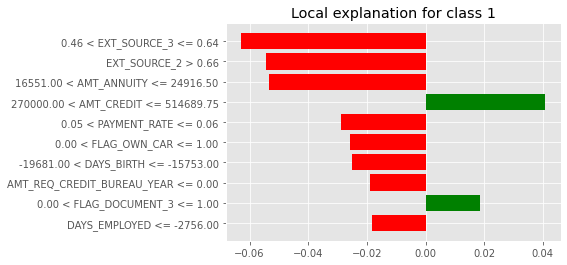

In [86]:
with plt.style.context("ggplot"):
    exp.as_pyplot_figure()
    plt.show()

In [87]:
print(X_test)
X_test_fs_id_cli = pd.concat([X_test, app_train.iloc[test_index][['SK_ID_CURR']]], axis = 1)
id_cli = 387758
print(X_test_fs_id_cli[X_test_fs_id_cli['SK_ID_CURR'] == id_cli].drop(['SK_ID_CURR'], axis =1))

        CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
248727            1             1                0             0   
263686            0             1                0             0   
264746            0             1                0             1   
139119            1             1                0             1   
23810             1             0                0             0   
...             ...           ...              ...           ...   
95738             1             0                0             0   
61549             1             0                1             2   
55473             0             1                0             0   
32719             1             0                0             0   
52089             0             0                0             0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  \
248727           90000.0    360000.0      20232.0                    0.009630   
263686          30600

In [88]:
app_train.iloc[test_index]

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
248727      387758       0            1             1                0   
263686      405300       0            0             1                0   
264746      406580       0            0             1                0   
139119      261310       0            1             1                0   
23810       127703       0            1             0                0   
...            ...     ...          ...           ...              ...   
95738       211142       0            1             0                0   
61549       171385       0            1             0                1   
55473       164279       0            0             1                0   
32719       137920       0            1             0                0   
52089       160325       0            0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
248727             0           90000.0    360000.0      20232.0   
263686             0          306000.0    865953.0      32980.5   
264746             1          225000.0    180000.0       9000.0   
139119             1          157500.0    528633.0      22527.0   
23810              0          112500.0     59346.0       4725.0   
...              ...               ...         ...          ...   
95738              0          135000.0   1336873.5      35977.5   
61549              2           90000.0    373500.0      10399.5   
55473              0          148500.0    216630.0      17113.5   
32719              0          261000.0    323388.0      34443.0   
52089              0          450000.0    497520.0      52920.0   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
248727                    0.009630      -17756        -6514.0   
263686                    0.008575       -9293        -1399.0   
264746                    0.010147      -10621         -762.0   
139119                    0.018850      -16581        -9240.0   
23810                     0.016612      -14169         -935.0   
...                            ...         ...            ...   
95738                     0.022625      -23179        -5746.0   
61549                     0.031329      -13482        -1834.0   
55473                     0.026392      -11247        -1778.0   
32719                     0.002042       -8937         -224.0   
52089                     0.046220      -13089        -3293.0   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
248727            -6562.0            -1317          8.0           1   
263686            -5737.0            -1460          3.0           1   
264746            -2123.0            -3173         14.0           1   
139119             -798.0             -130          0.0           1   
23810             -8243.0            -5188          0.0           1   
...                   ...              ...          ...         ...   
95738              -218.0            -4255          0.0           1   
61549             -6328.0            -4170          0.0           1   
55473             -3521.0            -3936         11.0           1   
32719              -715.0            -1602          0.0           1   
52089              -476.0            -1800          0.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
248727               1                1                 1           1   
263686               1                0                 1           0   
264746               1                1                 1           1   
139119               1                0                 1           0   
23810                1                0                 1           0   
...                ...              ...               ...         ...   
95738                1                0                 1           0   
61549                1                0                 1           1   
55473                1 